# Load data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/task1_dataset_kotae.csv")


In [3]:
df

,uid,d,t,x,y
0,0,0,1,79,86
1,0,0,2,79,86
2,0,0,8,77,86
3,0,0,9,77,86
4,0,0,19,81,89
...,...,...,...,...,...
111535170,99999,74,38,119,77
111535171,99999,74,39,132,94
111535172,99999,74,40,124,105
111535173,99999,74,41,121,107


In [4]:
df.shape

(111535175, 5)

In [5]:
print(df['x'].max(),df['x'].min())
print(df['y'].max(),df['x'].min())
print(df['t'].max(),df['t'].min())

200 1
200 1
47 0


In [7]:
count_table = df.value_counts(['x', 'y','t','d']).reset_index(name='number of people')


In [8]:
count_table

,x,y,t,d,number of people
0,135,77,36,68,301
1,135,77,36,66,297
2,135,77,37,68,296
3,135,77,36,54,295
4,135,77,36,26,295
...,...,...,...,...,...
39081331,1,1,0,54,1
39081332,1,1,0,46,1
39081333,1,1,0,45,1
39081334,1,1,0,40,1


In [9]:
count_table
# count_table.to_csv('../data/task1_dataset_kotae_cnt_result.csv', index=False)

,x,y,t,d,number of people
0,135,77,36,68,301
1,135,77,36,66,297
2,135,77,37,68,296
3,135,77,36,54,295
4,135,77,36,26,295
...,...,...,...,...,...
39081331,1,1,0,54,1
39081332,1,1,0,46,1
39081333,1,1,0,45,1
39081334,1,1,0,40,1


In [10]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [11]:
count_table

,x,y,t,d,number of people
0,135,77,36,68,301
1,135,77,36,66,297
2,135,77,37,68,296
3,135,77,36,54,295
4,135,77,36,26,295
...,...,...,...,...,...
39081331,1,1,0,54,1
39081332,1,1,0,46,1
39081333,1,1,0,45,1
39081334,1,1,0,40,1


In [12]:
count_table_for_analyse = df.value_counts(['x', 'y']).reset_index(name='number of people')


In [13]:
count_table_for_analyse

,x,y,number of people
0,135,77,359963
1,135,82,196083
2,134,77,176167
3,129,81,151722
4,135,78,140375
...,...,...,...
34027,122,165,1
34028,44,126,1
34029,200,168,1
34030,122,178,1


In [14]:

count_table_for_analysis = count_table_for_analyse



In [15]:

# 1. 找出 'number of people' 欄位值前三大的資料
top_3_locations = count_table_for_analysis.nlargest(3, 'number of people')

print("人口數前三多的地點 (x, y):")
print(top_3_locations)
print("-" * 30)


人口數前三多的地點 (x, y):
     x   y  number of people
0  135  77            359963
1  135  82            196083
2  134  77            176167
------------------------------


In [16]:

# 2. 從這三筆資料中選取 'x' 和 'y' 欄位，用於後續的匹配
locations_to_find = top_3_locations[['x', 'y']]


In [17]:

# 3. 使用 merge 方法，根據 x 和 y 找出在 count_table 中所有符合的資料
#    'how='inner'' 表示只保留兩個 DataFrame 中 x, y 組合都存在的資料列
result_df = pd.merge(count_table, locations_to_find, on=['x', 'y'], how='inner')

print("在 count_table 中找到符合前三多地點 (x, y) 的所有資料:")
print(result_df)

在 count_table 中找到符合前三多地點 (x, y) 的所有資料:
         x   y   t   d  number of people
0      135  77  36  68               301
1      135  77  36  66               297
2      135  77  37  68               296
3      135  77  36  54               295
4      135  77  36  26               295
...    ...  ..  ..  ..               ...
10792  134  77   6  15                 1
10793  134  77   6   8                 1
10794  134  77   6   2                 1
10795  134  77   5  56                 1
10796  134  77   0  17                 1

[10797 rows x 5 columns]


In [18]:
result_df

,x,y,t,d,number of people
0,135,77,36,68,301
1,135,77,36,66,297
2,135,77,37,68,296
3,135,77,36,54,295
4,135,77,36,26,295
...,...,...,...,...,...
10792,134,77,6,15,1
10793,134,77,6,8,1
10794,134,77,6,2,1
10795,134,77,5,56,1


# Train

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [20]:
class GridTimeSeriesDataset(Dataset):
    def __init__(self, df, group_by_cols, target_col, input_seq_len, output_seq_len):
        """
        Args:
            df (pd.DataFrame): 包含所有網格點和時間的 DataFrame
            group_by_cols (list): 用於分組的欄位，例如 ['x', 'y']
            target_col (str): 要預測的目標欄位，例如 'number of people'
            input_seq_len (int): 輸入序列的長度 (例如 144 -> 過去72小時)
            output_seq_len (int): 輸出序列的長度 (例如 48 -> 未來24小時)
        """
        self.group_by_cols = group_by_cols
        self.target_col = target_col
        self.input_seq_len = input_seq_len
        self.output_seq_len = output_seq_len
        
        self.sequences = []
        self._create_sequences(df)

    def _create_sequences(self, df):
        # 根據網格點分組，為每個網格點建立序列
        grouped = df.groupby(self.group_by_cols)
        
        for _, group_df in grouped:
            # 確保每個分組內的資料是按時間排序的
            group_df = group_df.sort_values(['d', 't'])
            values = group_df[self.target_col].values
            
            # 使用滑動窗口建立 (輸入, 輸出) 配對
            total_len = len(values)
            for i in range(total_len - self.input_seq_len - self.output_seq_len + 1):
                input_seq = values[i : i + self.input_seq_len]
                output_seq = values[i + self.input_seq_len : i + self.input_seq_len + self.output_seq_len]
                
                self.sequences.append((input_seq, output_seq))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        input_seq, output_seq = self.sequences[idx]
        
        # 轉換為 PyTorch Tensor，並增加一個特徵維度
        # LSTM 的輸入格式為 (sequence_length, num_features)
        input_tensor = torch.FloatTensor(input_seq).unsqueeze(-1)
        output_tensor = torch.FloatTensor(output_seq).unsqueeze(-1)
        
        return input_tensor, output_tensor

In [21]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        outputs, (hidden, cell) = self.lstm(x)
        # 回傳 outputs 和 (hidden, cell) tuple
        return outputs, (hidden, cell)  # ← 改成回傳 tuple

class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # x shape: (batch_size, 1, output_size)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        # output shape: (batch_size, 1, hidden_size)
        prediction = self.fc(output.squeeze(1)) # shape: (batch_size, output_size)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, target_len, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.target_len = target_len
        self.device = device
        # 刪除 self.fc，因為 Decoder 內部已經包含輸出層了
        
    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        output_size = self.decoder.output_size 
        
        # Encoder: 正確接收
        _, (hidden, cell) = self.encoder(src)  # ← 這樣寫就對了

        # Decoder
        # 準備 Decoder 的第一個輸入
        decoder_input = torch.zeros(batch_size, 1, output_size, device=src.device).float()
        
        outputs = []

        predict_len = self.target_len 

        for t in range(predict_len):
            prediction, hidden, cell = self.decoder(decoder_input, hidden, cell)
            
            outputs.append(prediction)
            decoder_input = prediction.unsqueeze(1)

        outputs = torch.stack(outputs, dim=1)  # shape: (batch_size, seq_len, output_size)
        return outputs

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
import os

In [24]:
# 1. 參數設定
INPUT_SEQ_LEN = 144   # 過去 72 小時
OUTPUT_SEQ_LEN = 48   # 未來 24 小時
BATCH_SIZE = 512
INPUT_SIZE = 1
OUTPUT_SIZE = 1
HIDDEN_SIZE = 256
NUM_LAYERS = 4
EPOCHS = 200          # 最大 epoch
PATIENCE = 20         # Early Stopping 耐心值
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [25]:

# 2. 準備資料
scaler = MinMaxScaler()
result_df['number of people'] = scaler.fit_transform(result_df[['number of people']])


In [26]:

# 固定切分：40/10/25 天
TRAIN_DAYS = 40
VAL_DAYS = 10
TEST_DAYS = 25

train_df = result_df[result_df['d'] < TRAIN_DAYS]
val_df = result_df[(result_df['d'] >= TRAIN_DAYS) & (result_df['d'] < TRAIN_DAYS + VAL_DAYS)]
test_df = result_df[result_df['d'] >= TRAIN_DAYS + VAL_DAYS]

print(f"訓練集天數: 0 ~ {TRAIN_DAYS-1} (共 {TRAIN_DAYS} 天)")
print(f"驗證集天數: {TRAIN_DAYS} ~ {TRAIN_DAYS+VAL_DAYS-1} (共 {VAL_DAYS} 天)")
print(f"測試集天數: {TRAIN_DAYS+VAL_DAYS} ~ 74 (共 {TEST_DAYS} 天)")

train_dataset = GridTimeSeriesDataset(train_df, group_by_cols=['x', 'y'], 
                                       target_col='number of people', 
                                       input_seq_len=INPUT_SEQ_LEN, 
                                       output_seq_len=OUTPUT_SEQ_LEN)
val_dataset = GridTimeSeriesDataset(val_df, group_by_cols=['x', 'y'], 
                                     target_col='number of people', 
                                     input_seq_len=INPUT_SEQ_LEN, 
                                     output_seq_len=OUTPUT_SEQ_LEN)
test_dataset = GridTimeSeriesDataset(test_df, group_by_cols=['x', 'y'], 
                                      target_col='number of people', 
                                      input_seq_len=INPUT_SEQ_LEN, 
                                      output_seq_len=OUTPUT_SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")


訓練集天數: 0 ~ 39 (共 40 天)
驗證集天數: 40 ~ 49 (共 10 天)
測試集天數: 50 ~ 74 (共 25 天)
Training samples: 5185
Validation samples: 867
Testing samples: 3026


In [27]:

# 3. 建立模型
encoder = Encoder(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)
decoder = Decoder(OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)
model = Seq2Seq(encoder, decoder, OUTPUT_SEQ_LEN, DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


Epoch 1/200 | Train Loss: 0.013546 | Val Loss: 0.011357
  ✓ Best model updated (Val Loss: 0.011357)
Epoch 2/200 | Train Loss: 0.013633 | Val Loss: 0.011680
  No improvement (1/20)
Epoch 3/200 | Train Loss: 0.012956 | Val Loss: 0.009182
  ✓ Best model updated (Val Loss: 0.009182)
Epoch 4/200 | Train Loss: 0.010685 | Val Loss: 0.007628
  ✓ Best model updated (Val Loss: 0.007628)
Epoch 5/200 | Train Loss: 0.009298 | Val Loss: 0.006891
  ✓ Best model updated (Val Loss: 0.006891)
Epoch 6/200 | Train Loss: 0.008777 | Val Loss: 0.006351
  ✓ Best model updated (Val Loss: 0.006351)
Epoch 7/200 | Train Loss: 0.008309 | Val Loss: 0.006191
  ✓ Best model updated (Val Loss: 0.006191)
Epoch 8/200 | Train Loss: 0.007626 | Val Loss: 0.005752
  ✓ Best model updated (Val Loss: 0.005752)
Epoch 9/200 | Train Loss: 0.007498 | Val Loss: 0.005268
  ✓ Best model updated (Val Loss: 0.005268)
Epoch 10/200 | Train Loss: 0.007154 | Val Loss: 0.007877
  No improvement (1/20)
Epoch 11/200 | Train Loss: 0.008360 | V

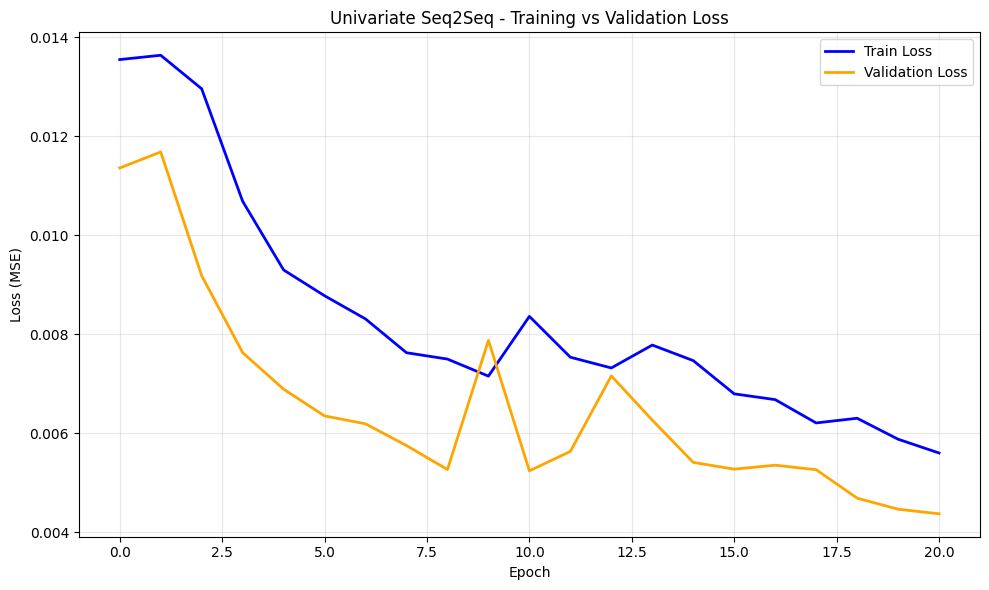

Training Loss 曲線已儲存至 ../models/training_loss_univariate.png


In [ ]:

# 4. 訓練迴圈 (含 Early Stopping)

RETRAIN = True  # 設為 False 可跳過訓練


if RETRAIN or not os.path.exists("../models/seq2seq_model.pth"):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # 記錄 Loss 的列表
    train_losses = []
    val_losses = []
    
    for epoch in range(EPOCHS):
        model.train()
        total_train_loss = 0
        for input_seq, target_seq in train_loader:
            input_seq = input_seq.to(DEVICE)
            target_seq = target_seq.to(DEVICE)
            optimizer.zero_grad()
            output = model(input_seq)
            loss = criterion(output, target_seq)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        
        # 驗證階段（使用 val_loader）
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for input_seq, target_seq in val_loader:
                input_seq = input_seq.to(DEVICE)
                target_seq = target_seq.to(DEVICE)
                output = model(input_seq)
                val_loss = criterion(output, target_seq)
                total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        
        # 記錄 Loss
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        
        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"  ✓ Best model updated (Val Loss: {best_val_loss:.6f})")
        else:
            patience_counter += 1
            print(f"  No improvement ({patience_counter}/{PATIENCE})")
            
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered at epoch {epoch+1}!")
            break
    
    # 載入最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print("\n訓練完成！")

    # 繪製並儲存 Training Loss 曲線
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Univariate Seq2Seq - Training vs Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../models/training_loss_univariate.png', dpi=150)
    plt.show()
    print("Training Loss 曲線已儲存至 ../models/training_loss_univariate.png")

In [30]:
# === 儲存模型 ===
import os
import joblib

# 建立儲存目錄
save_dir = "../models"
os.makedirs(save_dir, exist_ok=True)

# 儲存模型權重和超參數
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'input_size': INPUT_SIZE,
        'output_size': OUTPUT_SIZE,
        'hidden_size': HIDDEN_SIZE,
        'num_layers': NUM_LAYERS,
        'input_seq_len': INPUT_SEQ_LEN,
        'output_seq_len': OUTPUT_SEQ_LEN,
    }
}, f"{save_dir}/seq2seq_model.pth")

# 儲存 scaler
joblib.dump(scaler, f"{save_dir}/scaler.pkl")

print(f"模型已儲存至 {save_dir}/seq2seq_model.pth")
print(f"Scaler 已儲存至 {save_dir}/scaler.pkl")

模型已儲存至 ../models/seq2seq_model.pth
Scaler 已儲存至 ../models/scaler.pkl


# Inference

In [32]:
# === 載入模型 ===
import joblib

# 載入 checkpoint
checkpoint = torch.load("../models/seq2seq_model.pth", map_location=DEVICE)
hp = checkpoint['hyperparameters']

# 重建模型架構
encoder_loaded = Encoder(hp['input_size'], hp['hidden_size'], hp['num_layers']).to(DEVICE)
decoder_loaded = Decoder(hp['output_size'], hp['hidden_size'], hp['num_layers']).to(DEVICE)
model_loaded = Seq2Seq(encoder_loaded, decoder_loaded, hp['output_seq_len'], DEVICE).to(DEVICE)

# 載入權重
model_loaded.load_state_dict(checkpoint['model_state_dict'])
model_loaded.eval()

# 載入 scaler
scaler_loaded = joblib.load("../models/scaler.pkl")

print("模型載入成功！")

模型載入成功！


In [33]:
# === 推論函數 ===
import numpy as np

def predict(model, input_sequence, scaler, device):
    """
    對單一輸入序列進行預測
    
    Args:
        model: 訓練好的 Seq2Seq 模型
        input_sequence: numpy array, shape (seq_len,) 或 (seq_len, 1)
        scaler: MinMaxScaler
        device: 運算裝置
    
    Returns:
        預測結果（已反標準化）
    """
    model.eval()
    
    with torch.no_grad():
        # 標準化輸入
        input_normalized = scaler.transform(input_sequence.reshape(-1, 1))
        
        # 轉換為 tensor
        input_tensor = torch.FloatTensor(input_normalized).unsqueeze(0).to(device)
        
        # 預測
        output = model(input_tensor)
        
        # 反標準化
        output_np = output.cpu().numpy().reshape(-1, 1)
        prediction = scaler.inverse_transform(output_np)
        
    return prediction.flatten()

In [35]:
# === 推論測試（使用測試集）===
# 從 test_dataset 取一個樣本
sample_input, sample_target = test_dataset[0]
# 反標準化取得原始值
sample_input_original = scaler_loaded.inverse_transform(
    sample_input.numpy().reshape(-1, 1)
).flatten()
# 進行預測
predicted_values = predict(model_loaded, sample_input_original, scaler_loaded, DEVICE)
# 真實值
actual_values = scaler_loaded.inverse_transform(
    sample_target.numpy().reshape(-1, 1)
).flatten()

print(f"輸入序列長度: {len(sample_input_original)}")
print(f"預測序列長度: {len(predicted_values)}")
print(f"\n預測結果（前 10 個時間步）:\n{predicted_values[:10]}")
print(f"\n實際值（前 10 個時間步）:\n{actual_values[:10]}")

輸入序列長度: 144
預測序列長度: 48

預測結果（前 10 個時間步）:
[13.331849  11.199295   9.348124   7.544034   6.505183   5.99755
  5.284943   3.7172308  1.7736899  1.5764778]

實際值（前 10 個時間步）:
[9.        7.        9.        8.        3.9999998 9.        3.
 7.        5.0000005 3.9999998]


c:\Users\88697\Desktop\school\人工智慧\term_term\114-1-ai-hw-submit\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# Evaluate our Model

In [37]:
# === 評估模型 ===
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_on_dataset(model, dataloader, scaler, device):
    """評估整個 dataset 的效能"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for input_seq, target_seq in dataloader:
            input_seq = input_seq.to(device)
            output = model(input_seq)
            
            all_preds.append(output.cpu().numpy())
            all_targets.append(target_seq.numpy())
    
    # 合併
    preds = np.concatenate(all_preds, axis=0).reshape(-1, 1)
    targets = np.concatenate(all_targets, axis=0).reshape(-1, 1)
    
    # 反標準化
    preds_original = scaler.inverse_transform(preds).flatten()
    targets_original = scaler.inverse_transform(targets).flatten()
    
    # 計算指標
    mse = mean_squared_error(targets_original, preds_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets_original, preds_original)
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae}

# 執行評估
# 執行評估（使用測試集）
metrics = evaluate_on_dataset(model_loaded, test_loader, scaler_loaded, DEVICE)
print("模型評估結果:")
for name, value in metrics.items():
    print(f"   {name}: {value:.4f}")

模型評估結果:
   MSE: 434.9224
   RMSE: 20.8548
   MAE: 13.7643


測試集總數: 3026
正在搜尋人流波動明顯的樣本 (Max > 80)...
找到目標樣本 Index: 0 (最大人流: 100.00)


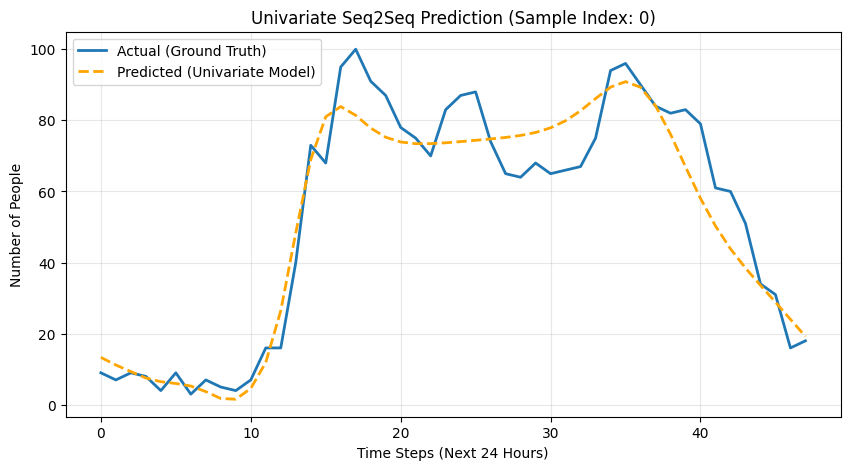

In [39]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# ==========================================
# 智慧搜尋與繪圖 (修正版)
# ==========================================

# 1. 使用測試集進行搜尋
total_len = len(test_dataset)
print(f"測試集總數: {total_len}")
target_sample_idx = 0
found = False
print("正在搜尋人流波動明顯的樣本 (Max > 80)...")
for i in range(total_len):
    _, target_tensor = test_dataset[i]
    
    temp_val = scaler_loaded.inverse_transform(target_tensor.numpy().reshape(-1, 1))
    
    if temp_val.max() > 80:
        target_sample_idx = i
        print(f"找到目標樣本 Index: {i} (最大人流: {temp_val.max():.2f})")
        found = True
        break
if not found:
    print("未找到 > 80 的樣本，將使用測試集的第一筆資料繪圖。")
# 從測試集取得樣本
input_tensor, target_tensor = test_dataset[target_sample_idx]

# 增加 Batch 維度 (變成 1, seq_len, 1) 並放上 GPU/CPU
input_batch = input_tensor.unsqueeze(0).to(DEVICE)

model_loaded.eval()
with torch.no_grad():
    prediction = model_loaded(input_batch)

# 4. 資料轉換與反標準化
# 預測結果
pred_np = prediction.cpu().numpy().reshape(-1, 1)
pred_orig = scaler_loaded.inverse_transform(pred_np).flatten()

# 真實結果
target_np = target_tensor.numpy().reshape(-1, 1)
target_orig = scaler_loaded.inverse_transform(target_np).flatten()

# 5. 畫圖
plt.figure(figsize=(10, 5))
plt.plot(target_orig, label='Actual (Ground Truth)', linewidth=2)
plt.plot(pred_orig, label='Predicted (Univariate Model)', linestyle='--', color='orange', linewidth=2)

plt.title(f"Univariate Seq2Seq Prediction (Sample Index: {target_sample_idx})")
plt.xlabel("Time Steps (Next 24 Hours)")
plt.ylabel("Number of People")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()